In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras import Model

# Load the dataset
dataframe = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# Remove labels
labels = raw_data[:, -1]

# Keep the rest of the data
data = raw_data[:, 0:-1]

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

In [ ]:
# Normalize data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# Convert labels to boolean values
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Filter normal beats
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# Filter abnormal beats
abnormal_train_data = train_data[~train_labels]
abnormal_test_data = test_data[~test_labels]

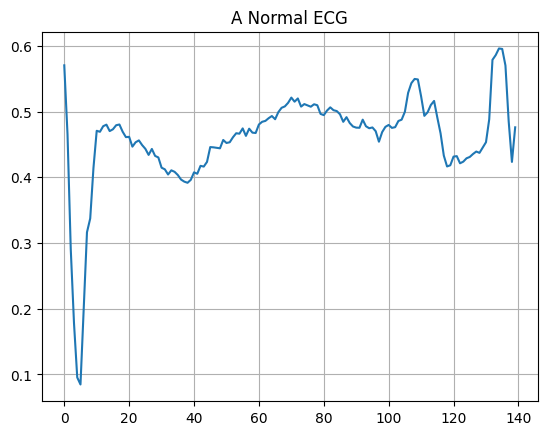

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

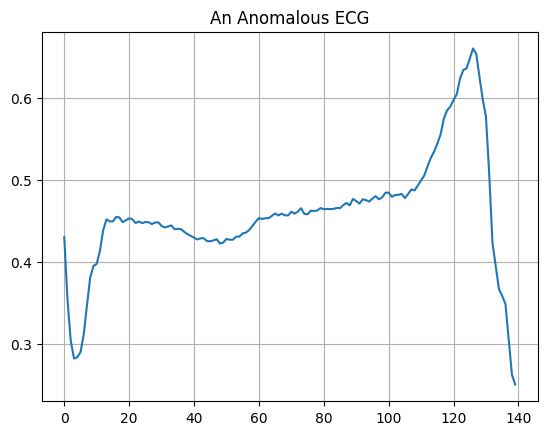

In [ ]:
plt.grid()
plt.plot(np.arange(140), abnormal_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
# Training
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 45ms/step - loss: 0.0598 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0561 - val_loss: 0.0514
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0531 - val_loss: 0.0492
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0492 - val_loss: 0.0477
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0449 - val_loss: 0.0454
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0404 - val_loss: 0.0431
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0365 - val_loss: 0.0416
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0330 - val_loss: 0.0401
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0302 - val_loss: 0.0389
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0283 - val_loss: 0.0382
Epoch 11/20
5/5 [============

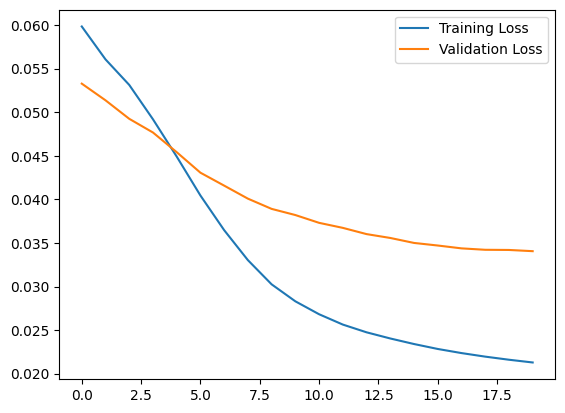

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

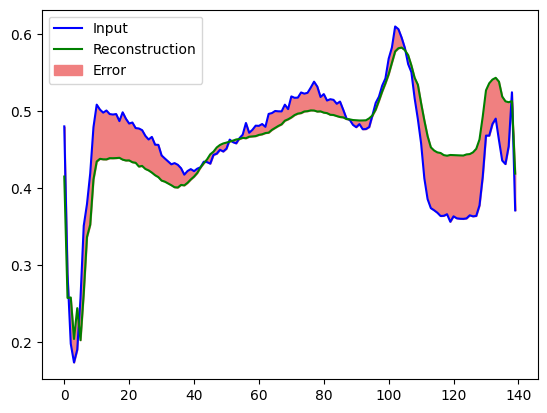

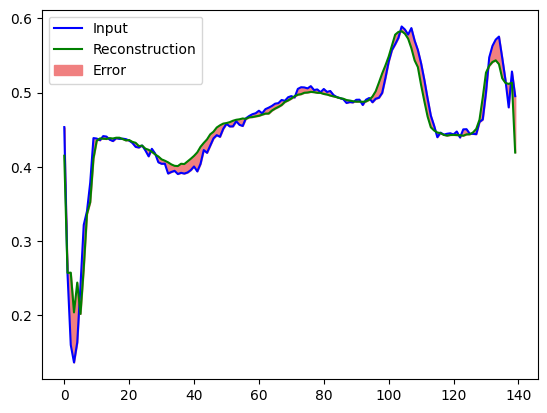

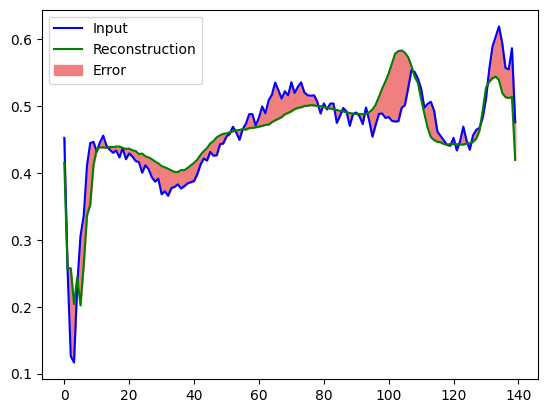

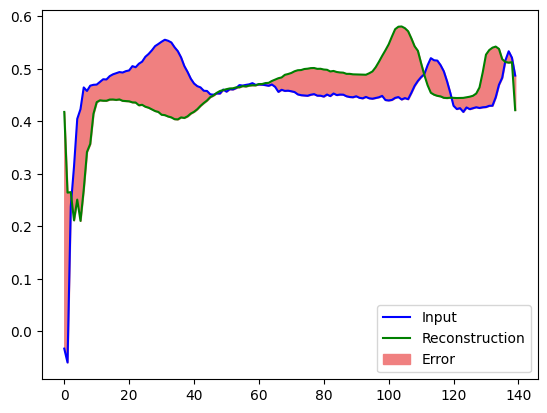

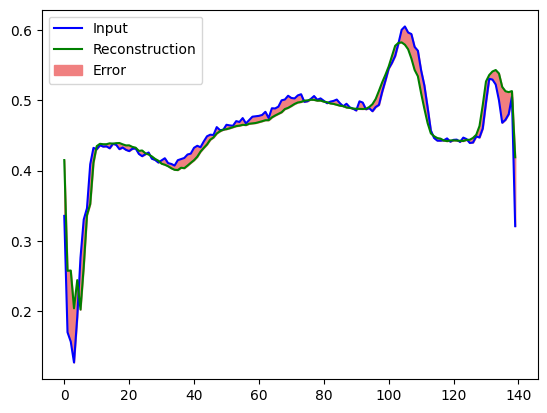

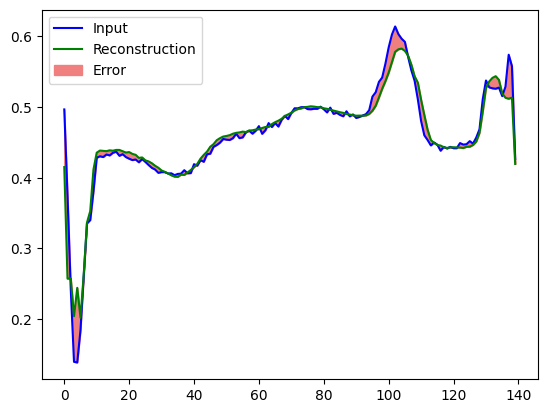

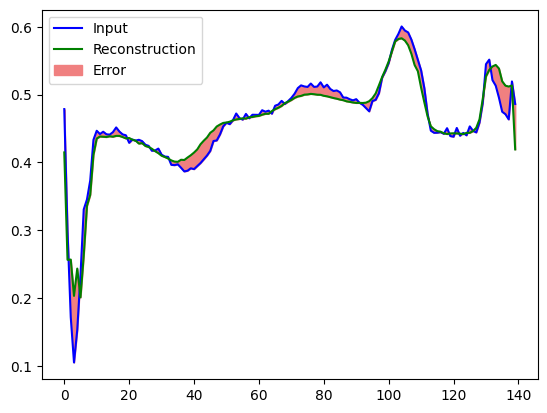

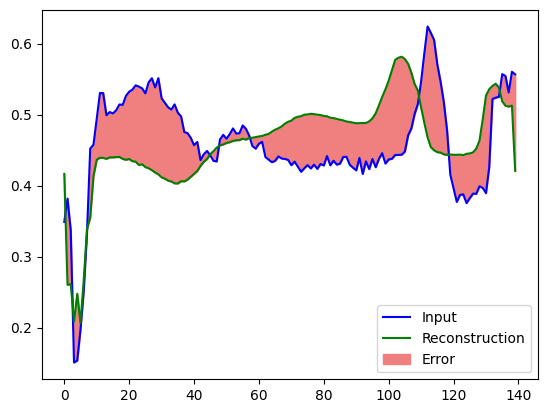

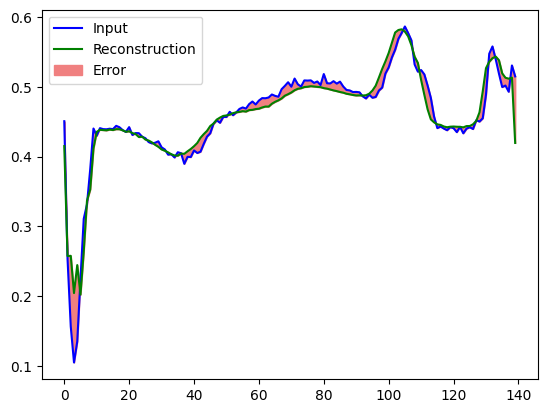

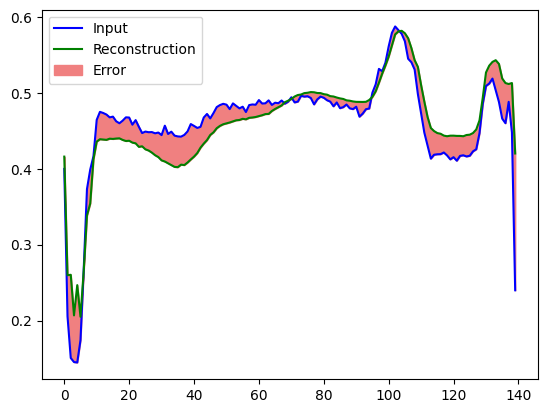

In [ ]:
# Encoding phase - normal ECGs
encoded_data = autoencoder.encoder(normal_test_data).numpy()
# Decoding phase
decoded_data = autoencoder.decoder(encoded_data).numpy()

for i in range(len(normal_test_data)-550):
  plt.plot(normal_test_data[i], 'b')
  plt.plot(decoded_data[i], 'g')
  plt.fill_between(np.arange(140), decoded_data[i], normal_test_data[i], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

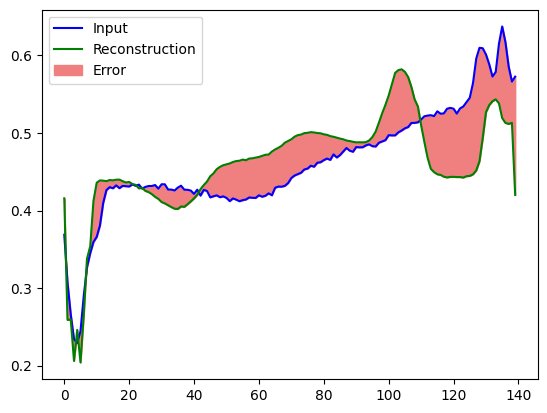

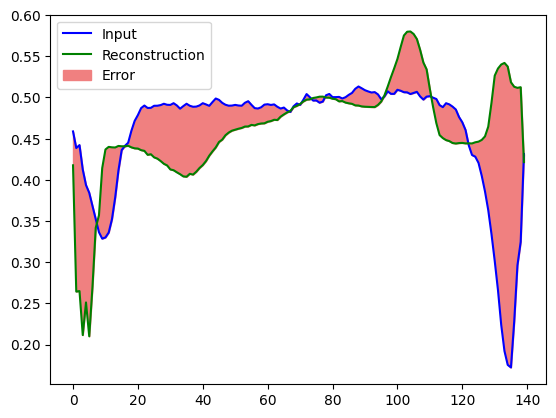

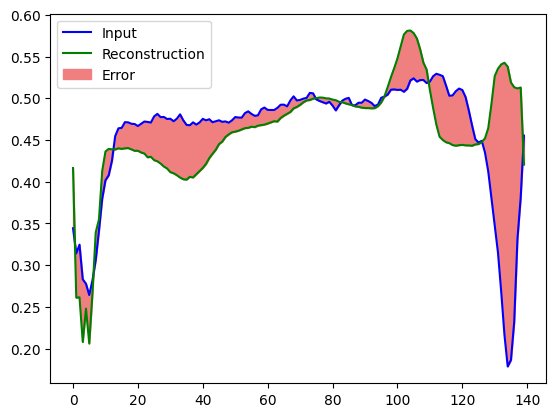

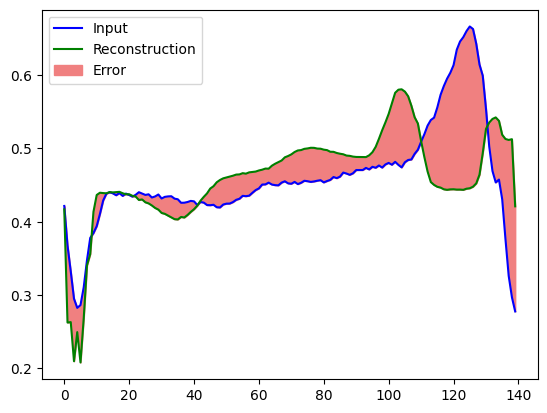

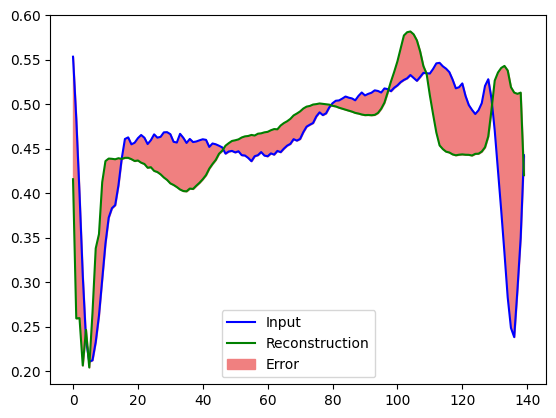

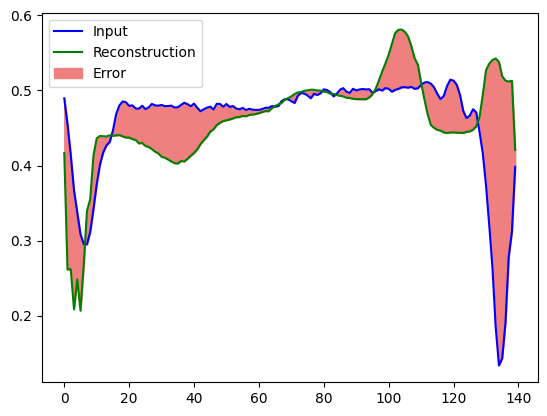

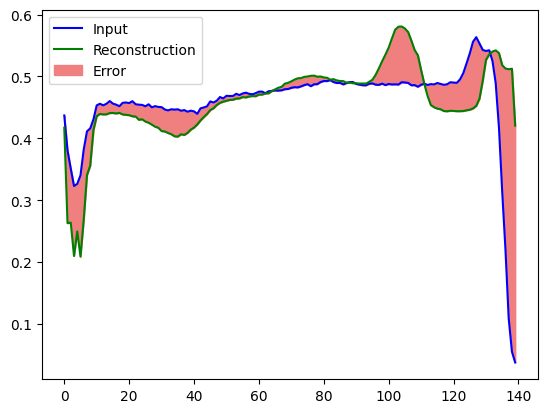

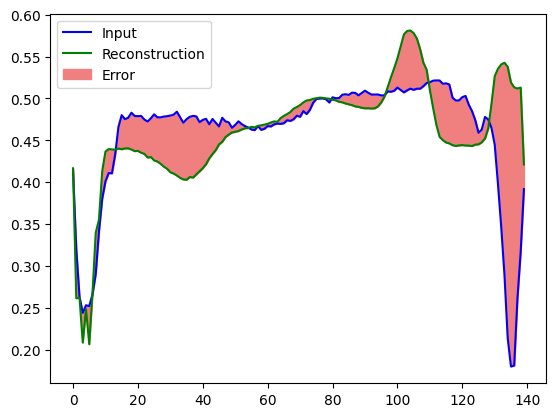

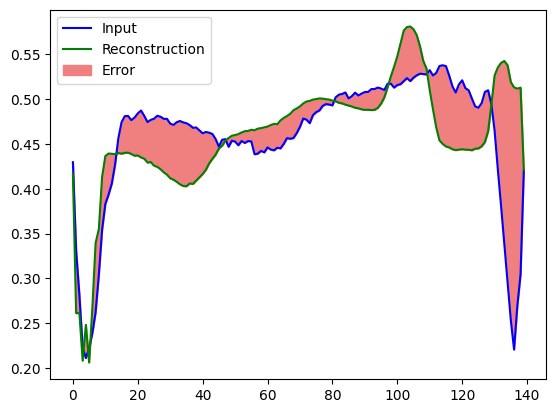

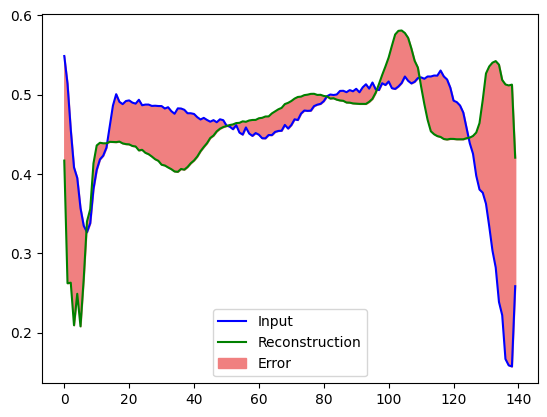

In [ ]:
encoded_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for i in range(len(abnormal_test_data)-430):
  plt.plot(abnormal_test_data[i], 'b')
  plt.plot(decoded_data[i], 'g')
  plt.fill_between(np.arange(140), decoded_data[i], abnormal_test_data[i], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

74/74 [==============================] - 0s 5ms/step


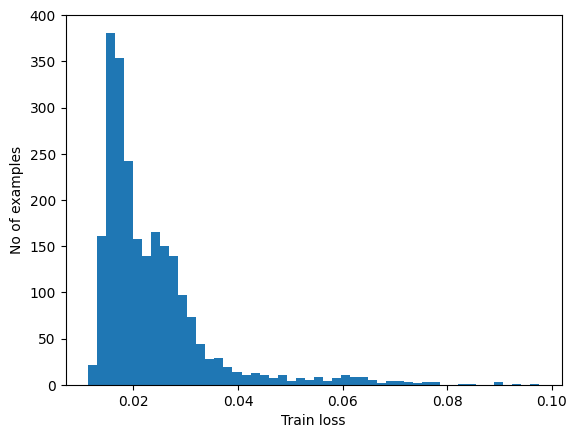

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.034468204


14/14 [==============================] - 0s 3ms/step


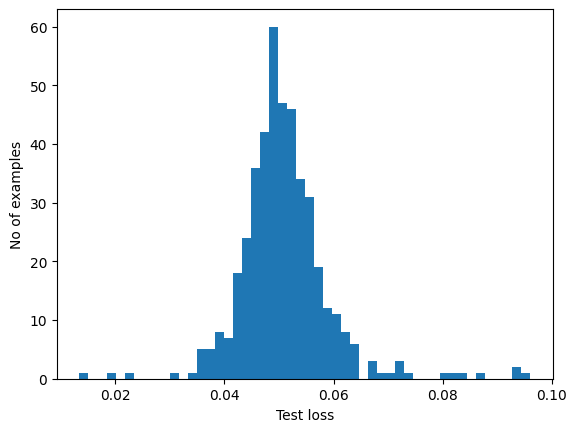

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
test_loss = tf.keras.losses.mae(reconstructions, abnormal_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(" Accuracy: {}".format(accuracy_score(labels, predictions)))
  print("Precision: {}".format(precision_score(labels, predictions)))
  print("   Recall: {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

 Accuracy: 0.948
Precision: 0.9903474903474904
   Recall: 0.9160714285714285
